In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import matplotlib.pyplot as plt

import os
# import pandas_profiling
datapath = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\dataset_2022'

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [20]:
datafile = 'duplicate_submission_data.csv'
data=pd.read_csv(os.path.join(datapath, datafile))
print(data.shape)
data.head(3)

(119, 9)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1
0,BENE117065,CLM123394,2009-01-06,2009-01-13,PRV52631,400,PHY355600,0.0,80399
1,BENE117065,CLM668829,2009-11-06,2009-11-06,PRV52652,20,PHY357307,0.0,V558
2,BENE117065,CLM242982,2009-03-12,2009-03-12,PRV52628,10,PHY432650,0.0,2878


## Graph Details
Nodes: BeneID, ClaimID, Provider, AttendingPhysician

Weight: BeneID - ClaimID (InscClaimAmtReimbursed)

Edge: BeneID - ClaimID, ClaimID - Provider, ClaimID - AttendingPhysician, Provider - AttendingPhysician


## Simple Graph and Bipartite

* Reference:  https://stackoverflow.com/questions/51865003/how-to-add-node-attributes-next-to-node-name-in-python-networkx


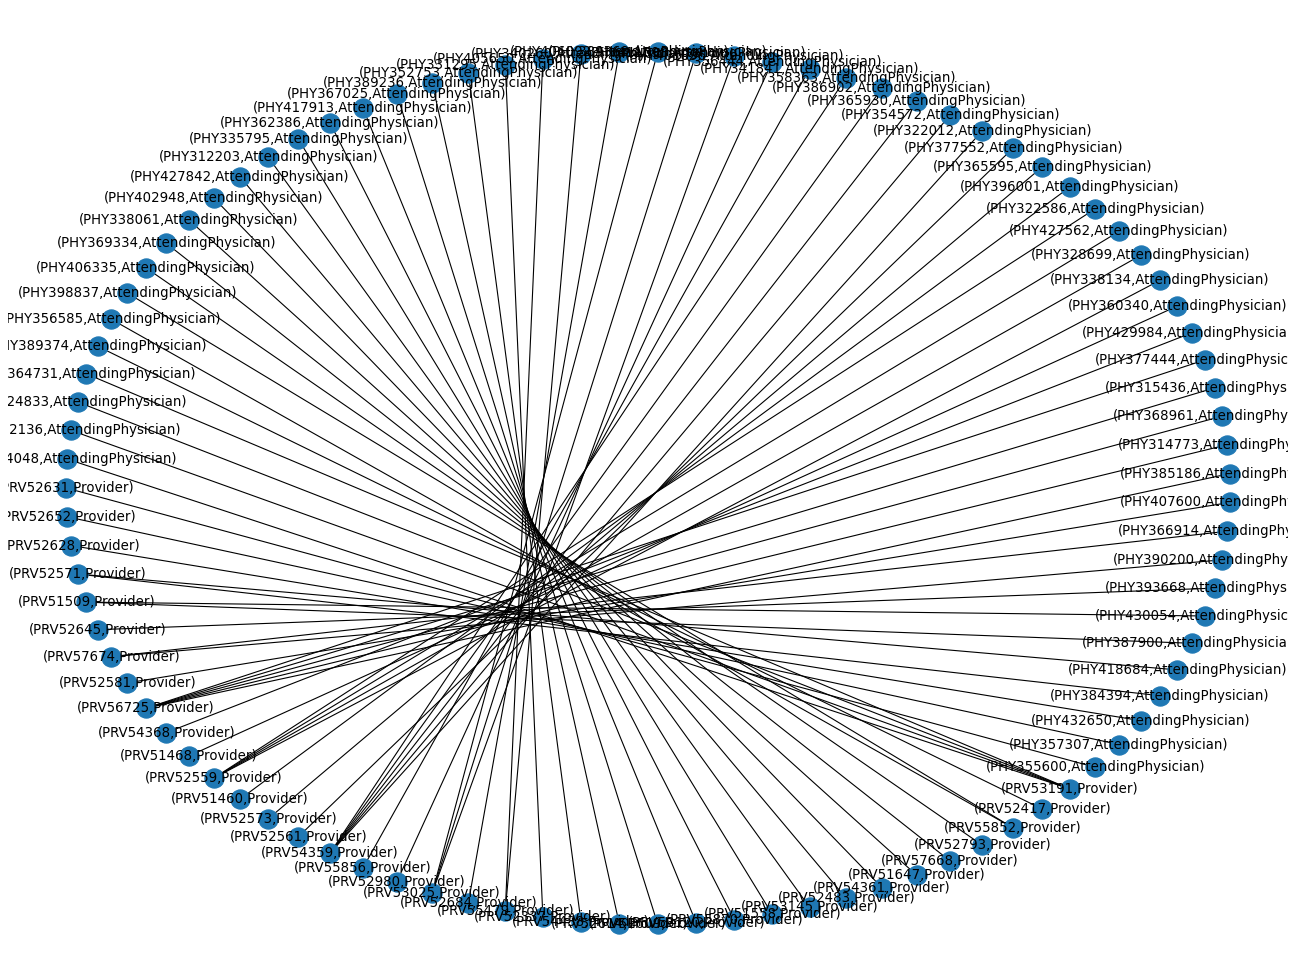

In [4]:
customized_edges = [['BeneID','ClaimID'], ['ClaimID', 'Provider'], ['ClaimID','AttendingPhysician'], ['Provider','AttendingPhysician']]

def get_G(data, edge_nodes):
    edge_list = []
    for edge in edge_nodes:
        edge_list += list(zip(data[edge[0]], data[edge[1]]))
    return(edge_list)
    
all_edges = get_G(data, customized_edges)

def create_simple_bipartite_graph(data, nodes):
    BG = nx.Graph()
    node1 = list(data[nodes[0]].unique())
    node2 = list(data[nodes[1]].unique())
    
    BG.add_nodes_from(node1, bipartite=0, _type=nodes[0])
    BG.add_nodes_from(node2, bipartite=1, _type=nodes[1])

    edges = get_G(data, [nodes])
    BG.add_edges_from(edges)
    labels = dict((n, "(" + n + "," + d['_type'] + ")") for n,d in BG.nodes(data=True))

    u = [n for n in BG.nodes if BG.nodes[n]['bipartite'] == 0]
    X, Y = nx.bipartite.sets(BG, top_nodes=u)

    # X, Y = bipartite.sets(BG)
    pos = dict()
    pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
    
    plt.figure(figsize=(16, 12), dpi=80)
    edges = BG.edges()
#     nx.draw_networkx(BG, pos, labels=labels)
#     nx.draw(BG, pos, labels=labels)
#     nx.draw(BG, pos=nx.circular_layout(BG), labels=labels)
    nx.draw(BG, pos=nx.shell_layout(BG), labels=labels)
#     nx.draw(BG, pos=nx.random_layout(BG), labels=labels)
    return(BG)

    
testG = create_simple_bipartite_graph(data, ['Provider','AttendingPhysician'])

In [12]:
testG_df = pd.DataFrame(list(testG.degree), columns=['Node', 'Degree'])
testG_df = testG_df.sort_values(by='Degree',ascending=False)
testG_df[testG_df.Degree>1]

,Node,Degree
15,PRV54359,5
8,PRV56725,5
36,PRV53191,4
11,PRV52559,4
18,PRV53025,3
3,PRV52571,2
4,PRV51509,2
6,PRV57674,2
34,PRV55852,2
20,PRV55479,2


In [24]:
data[data.Provider=='PRV54359']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1
39,BENE66512,CLM114762,2009-01-02,2009-01-02,PRV54359,50,PHY322012,0.0,72293
40,BENE66512,CLM212249,2009-02-24,2009-02-24,PRV54359,50,PHY354572,0.0,2723
41,BENE66512,CLM271235,2009-03-28,2009-03-28,PRV54359,600,PHY365930,0.0,29622
42,BENE66512,CLM284300,2009-04-04,2009-04-04,PRV54359,60,PHY386902,0.0,78902
43,BENE66512,CLM381856,2009-05-27,2009-05-27,PRV54359,0,PHY365930,0.0,31400
44,BENE66512,CLM381857,2009-05-27,2009-05-27,PRV54359,0,PHY365930,0.0,7239
45,BENE66512,CLM390954,2009-06-01,2009-06-01,PRV54359,20,PHY365930,0.0,2722
46,BENE66512,CLM524410,2009-08-14,2009-08-14,PRV54359,40,PHY358363,0.0,78869


In [6]:
dg_centrality = pd.DataFrame(nx.degree_centrality(testG).items(), columns=['item','value'])
cl_centrality = pd.DataFrame(nx.closeness_centrality(testG).items(), columns=['item','value'])
bet_centrality = pd.DataFrame(nx.betweenness_centrality(testG, normalized = True, endpoints = False).items(), columns=['item','value'])
pr = pd.DataFrame(nx.pagerank(testG, alpha = 0.8).items(), columns=['item','value'])
pr.sample(3)

,item,value
62,PHY322012,0.006784
91,PHY364731,0.007018
63,PHY354572,0.006784


## MultiGraph

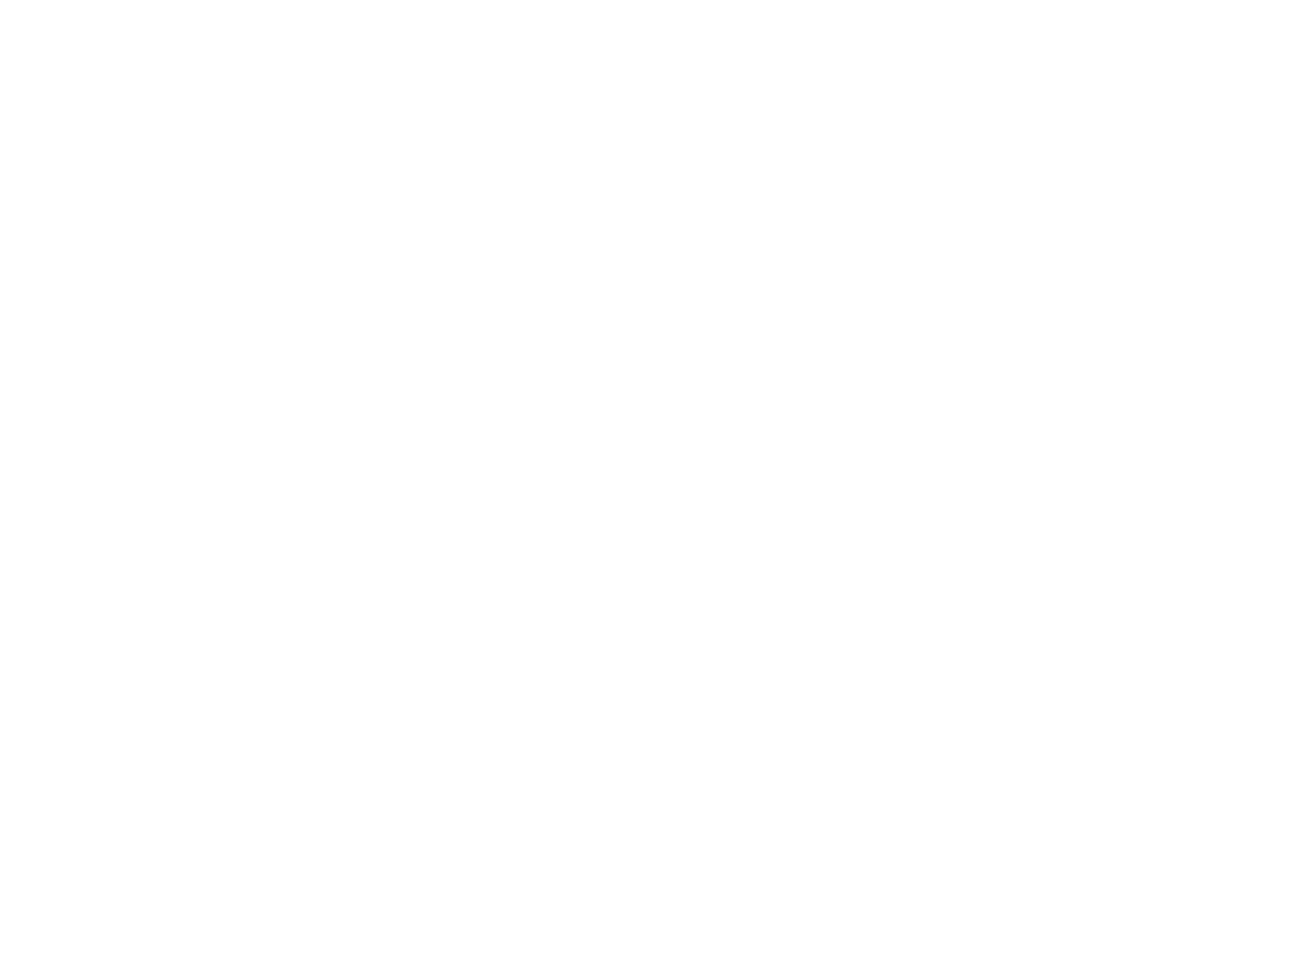

In [150]:
def create_multi_graph(data, node_list):
    BG = nx.MultiGraph()
    for nodes in node_list:
        node1 = list(data[nodes[0]].unique())
        node2 = list(data[nodes[1]].unique())

        BG.add_nodes_from(node1, bipartite=0, _type=nodes[0])
        BG.add_nodes_from(node2, bipartite=1, _type=nodes[1])

        edges = get_G(data, [nodes])
        BG.add_edges_from(edges)
    
    labels = dict((n, "(" + n + "," + d['_type'] + ")") for n,d in BG.nodes(data=True))


    plt.figure(figsize=(16, 12), dpi=80)
    edges = BG.edges()
#     nx.draw(BG, pos=nx.circular_layout(BG), labels=labels)
#     nx.draw(BG, pos=nx.shell_layout(BG), labels=labels)
    nx.draw(BG, pos=nx.random_layout(BG), labels=labels)
#     nx.draw(BG, pos=nx.draw_planar(BG), labels=labels)
    return(BG)

customized_edges = [['BeneID','ClaimID'], ['ClaimID', 'Provider'], ['ClaimID','AttendingPhysician'], ['Provider','AttendingPhysician']]
create_multi_graph(data[data.Provider=='PRV52228'], customized_edges)

In [15]:
datafile = 'top_3_community.csv'
data=pd.read_csv(os.path.join(datapath, datafile)).dropna(inplace=False)
print(data.shape)
data.head(3)

(6087, 10)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1,PotentialFraud
0,BENE11034,CLM31519,2008-12-29,2009-01-05,PRV55215,29000,PHY355604,1068.0,41041,Yes
1,BENE11183,CLM179719,2009-02-06,2009-02-06,PRV55215,40,PHY401601,0.0,V5481,Yes
2,BENE11183,CLM196321,2009-02-15,2009-02-15,PRV55215,600,PHY355633,0.0,7882,Yes


In [145]:
data[data.Provider=='PRV55510']
# data.Provider.value_counts()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1,PotentialFraud
5354,BENE11183,CLM611718,2009-10-03,2009-10-03,PRV55510,40,PHY418448,0.0,7850,No
5355,BENE11306,CLM708751,2009-12-01,2009-12-01,PRV55510,70,PHY400367,0.0,4019,No
5356,BENE11536,CLM210081,2009-02-23,2009-02-23,PRV55510,400,PHY393701,0.0,7248,No
5357,BENE11581,CLM164839,2009-01-29,2009-01-29,PRV55510,100,PHY324352,0.0,78061,No
5358,BENE12578,CLM225735,2009-03-03,2009-03-03,PRV55510,500,PHY395512,0.0,41021,No
...,...,...,...,...,...,...,...,...,...,...
6210,BENE157943,CLM366932,2009-05-18,2009-05-18,PRV55510,500,PHY393733,0.0,4561,No
6211,BENE158246,CLM359593,2009-05-14,2009-05-14,PRV55510,40,PHY391624,0.0,4019,No
6212,BENE158569,CLM558385,2009-09-02,2009-09-02,PRV55510,80,PHY376340,0.0,81230,No
6213,BENE158688,CLM487441,2009-07-24,2009-07-24,PRV55510,50,PHY389395,0.0,53085,No


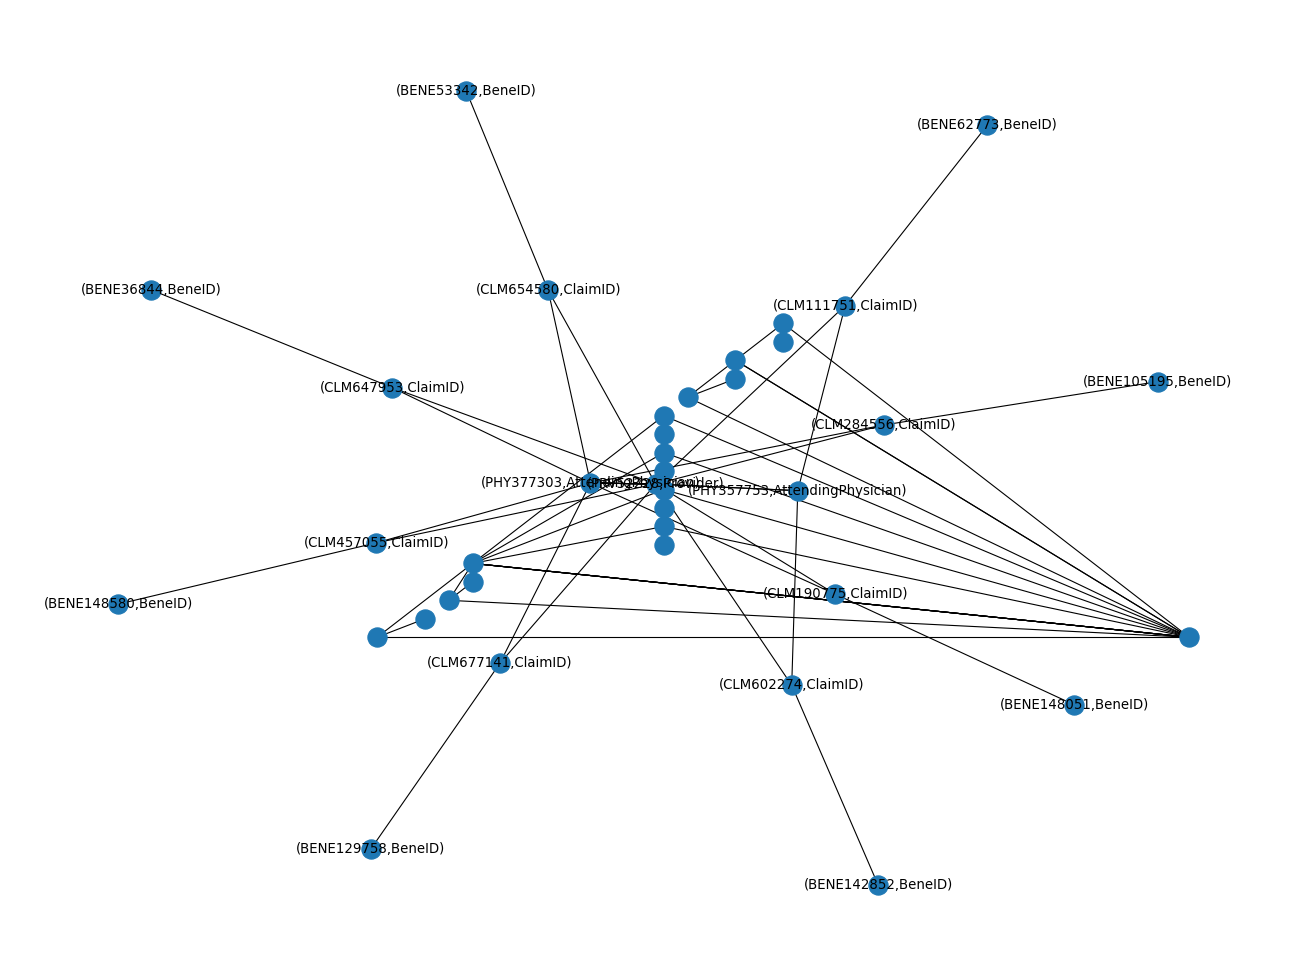

In [146]:
create_multi_graph(data[data.Provider=='PRV52228'], customized_edges)

In [147]:
datafile = 'fraud_provider_data.csv'
data=pd.read_csv(os.path.join(datapath, datafile)).dropna(inplace=False)
print(data.shape)
data.sample(3)


(207909, 10)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1,PotentialFraud
6983,BENE140216,CLM753478,2009-12-31,2009-12-31,PRV55215,400,PHY331351,0.0,37102,Yes
184234,BENE98264,CLM47640,2009-04-19,2009-04-25,PRV54391,5000,PHY366975,1068.0,8438,Yes
15587,BENE23767,CLM705618,2009-11-29,2009-11-29,PRV52649,40,PHY422221,0.0,4613,Yes


In [148]:
data[data.Provider=='PRV54391']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1,PotentialFraud
184171,BENE13680,CLM42671,2009-03-15,2009-03-16,PRV54391,9000,PHY313880,1068.0,73313,Yes
184172,BENE14787,CLM159371,2009-01-26,2009-01-26,PRV54391,30,PHY387384,0.0,V783,Yes
184173,BENE14787,CLM225752,2009-03-03,2009-03-03,PRV54391,0,PHY325209,0.0,V669,Yes
184174,BENE14787,CLM282977,2009-04-03,2009-04-03,PRV54391,40,PHY414889,0.0,24211,Yes
184175,BENE14787,CLM301565,2009-04-13,2009-04-13,PRV54391,600,PHY369547,0.0,88022,Yes
...,...,...,...,...,...,...,...,...,...,...
184483,BENE151912,CLM452646,2009-07-04,2009-07-04,PRV54391,50,PHY424835,0.0,2451,Yes
184484,BENE157665,CLM420713,2009-06-17,2009-06-17,PRV54391,200,PHY375684,0.0,36616,Yes
184486,BENE157717,CLM620242,2009-10-08,2009-10-28,PRV54391,100,PHY313909,0.0,V529,Yes
184487,BENE157717,CLM722882,2009-12-10,2009-12-10,PRV54391,10,PHY392819,0.0,4293,Yes


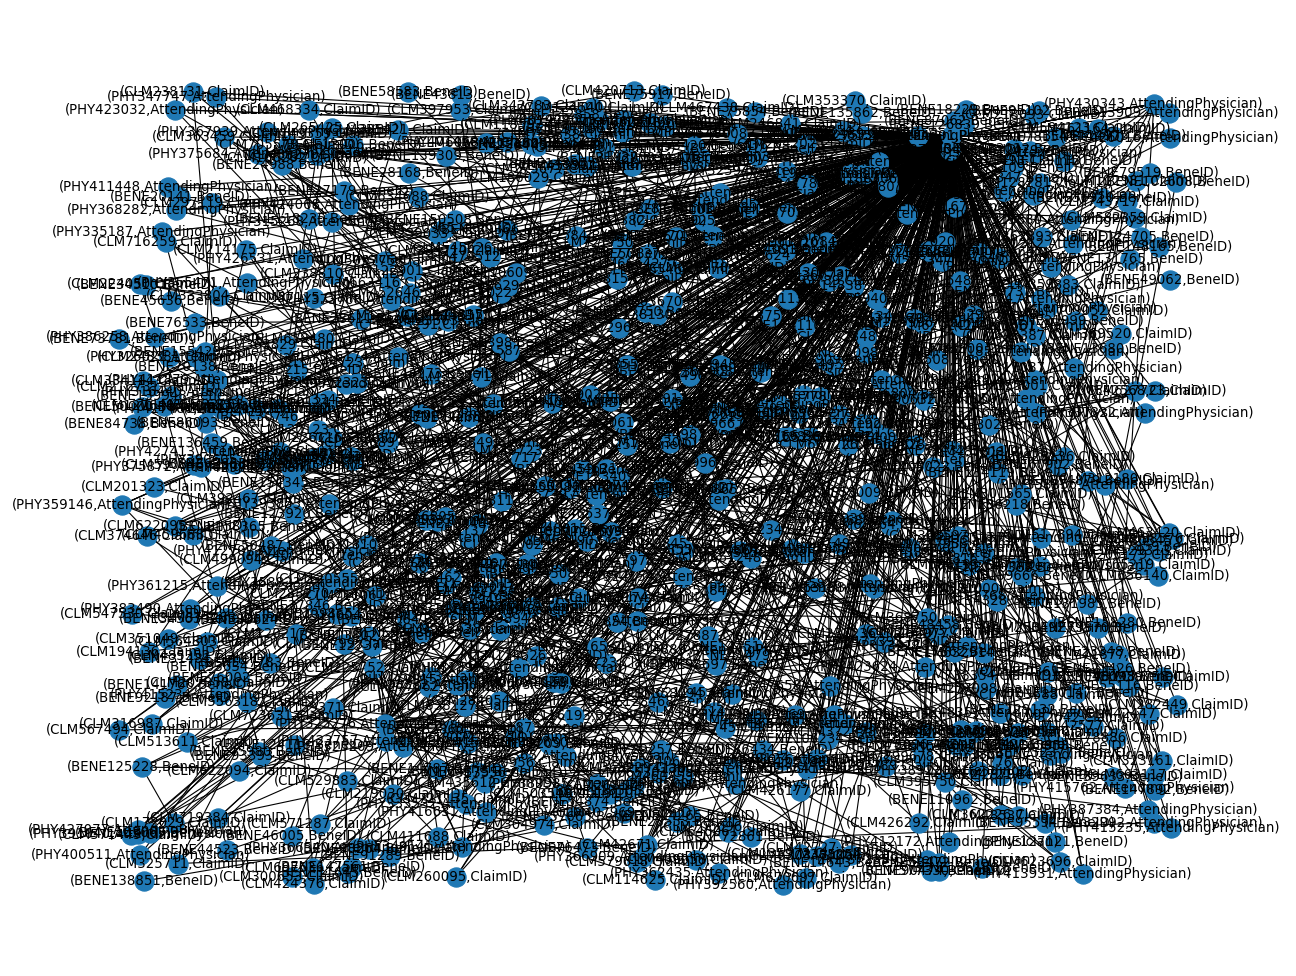

In [152]:
multi_G = create_multi_graph(data[data.Provider=='PRV54391'], customized_edges)

In [154]:
dg_centrality = pd.DataFrame(nx.degree_centrality(multi_G).items(), columns=['item','value'])
cl_centrality = pd.DataFrame(nx.closeness_centrality(multi_G).items(), columns=['item','value'])
pr = pd.DataFrame(nx.pagerank(multi_G, alpha = 0.8).items(), columns=['item','value'])
pr.sample(3)

,item,value
543,PHY386258,0.000892
125,BENE62167,0.001249
446,CLM719384,0.001201
